In [23]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph
from nsw.nsw_classifier import NSWClassifier
from nsw import rbf

In [105]:
import math
def draw_arc(r=0.8):
    angles = np.linspace(0, np.pi / 2, 30)
    x = [r*math.cos(a) for a in angles]
    y = [r*math.sin(a) for a in angles]
    plt.plot(x, y, ls='--')

In [108]:
N = 100
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p) > 0.8 else 0
    values.append((p, cls))

In [149]:
G = NSWGraph()
G.build_navigable_graph(values, attempts=3)

In [150]:
from sklearn.metrics.pairwise import euclidean_distances
X = np.array([x[0] for x in values])
Y = np.array([x[1] for x in values])

k = 5
S = 201
resultknn = np.ndarray((S, S))

for i, x in enumerate(np.linspace(0, 1, S)):
    for j, y in enumerate(np.linspace(0, 1, S)):
        p = np.array([[1-x, y]])
        dists = euclidean_distances(X, p).flatten()
        is1 = Y[np.argsort(dists)[:k]].sum() > k // 2
        resultknn[i, j] = int(is1)

In [146]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

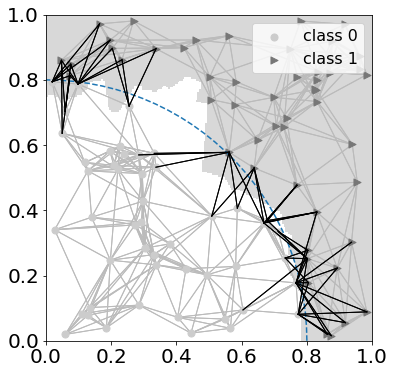

In [151]:
G.plot(.3, figsize=(6, 6), light='#BBBBBB')
plt.imshow(resultknn, interpolation='none', extent=[0, 1, 0, 1], cmap='Greys', vmin=0, vmax=4)
draw_arc()
plt.show()

In [132]:
to_remove = []
cut = []
support = []

for s, d in G.get_edges():
    if G.nodes[s]._class == G.nodes[d]._class:
        to_remove.append((s, d))
    else:
        cut.append((s, d) if G.nodes[s]._class < G.nodes[d]._class else (d, s))

cutdata = rich_cut = [
            (
                e, 
                G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value)
            ) 
            for e in cut
]

cutdata.sort(key=lambda x: x[1])
cutdata = cutdata[:len(cutdata) // 2]
print("Cut:", cutdata[0], "~", cutdata[-1], ", total", len(cutdata))
        
for s, d in to_remove:
    if d in G.nodes[s].neighbourhood:
        G.nodes[s].neighbourhood.remove(d)
    if s in G.nodes[d].neighbourhood:
        G.nodes[d].neighbourhood.remove(s)
        

support_share = 0.3

indices = np.array(range(len(G.nodes)))
np.random.shuffle(indices)
perc = int(len(indices) * support_share)
indices = indices[:perc]
Xsupport, Ysupport = X[indices][:perc], Y[indices][:perc]
support = list(zip(Xsupport, Ysupport))

Cut: ((19, 30), 0.035324586453002994) ~ ((11, 31), 0.21106133406740893) , total 101


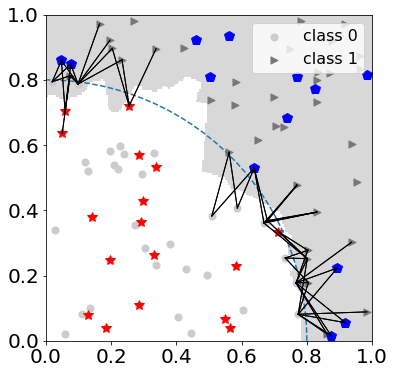

In [148]:
G.plot(cutdata[-1][1], figsize=(6, 6), light='#BBBBBB')
plt.imshow(resultknn, interpolation='none', extent=[0, 1, 0, 1], cmap='Greys', vmin=0, vmax=4)
Xsupport0 = Xsupport[Ysupport == 0]
Xsupport1 = Xsupport[Ysupport == 1]
plt.plot(Xsupport0[:, 0], Xsupport0[:, 1], c='red', ls='None', marker='*', markersize=10)
plt.plot(Xsupport1[:, 0], Xsupport1[:, 1], c='blue', ls='None', marker='p', markersize=10)
draw_arc()
plt.show()

In [134]:
def get_mid_shortest_dist(G, cut, sample=50):
    dists = []
    for i in range(sample):
        n0 = random.choice(cut)
        p0 = (G.nodes[n0[0][0]].value + G.nodes[n0[0][1]].value) / 2
        sd = []
        for n1 in cut:
            if n0 == n1:
                continue
            p1 = (G.nodes[n1[0][0]].value + G.nodes[n1[0][1]].value) / 2
            d = G.dist(p1, p0)
            sd.append(d)
        dists.append(min(sd))
    dists.sort()
    return dists[len(dists) // 2]

In [135]:
eps = get_mid_shortest_dist(G, cutdata)
print(eps)

0.013113084474729345


In [136]:
import sortedcontainers

supportG = NSWClassifier()
supportG.build_navigable_graph(support, attempts=10)

def get_classifier_function(G, cutdata, support_nsw, classes=None):
        '''Returns REAL 0..1 value of belonging to a class. Based on [Gradient theorem](https://en.wikipedia.org/wiki/Gradient_theorem)'''
    
        grad = rbf.get_grad_field_function(G, cutdata)
        eps = get_mid_shortest_dist(G, cutdata)
        
        def _f(x, R=2, small=0.001, closest=5, M=16, callback=None):
            # step 1. Closest support items
            vs, cs, rs = set(), sortedcontainers.SortedList(), sortedcontainers.SortedList()
            top, hops = support_nsw.search_nsw_basic(x, vs, cs, rs,  top=closest)
            top = top[:closest]
            
            # TBD implement multiclass voting
            votes = {0: 0, 1: 0}
            monitor = dict()
            
            for d, n in top[:closest]:
                val, class_ = support_nsw.nodes[n].value, support_nsw.nodes[n]._class
                r = x - val
                integral = 0.
                # step 2. Get integral along (d0 .. x) vector
                for i in range(M):
                    p = val + (r * i / M)
                    integral += np.dot(grad(p, eps * R), r)
                # print(f"<i={integral}>~<{class_}>\t", end="", )
                if abs(integral) < small:
                    votes[class_] += 1
                    monitor[n] = 0
                elif integral > small:
                    votes[1] += 1
                    monitor[n] = 1
                else:
                    votes[0] += 1
                    monitor[n] = -1
            # print(votes, end="")
            if callback is not None:
                callback(self, x, monitor)
            return votes[1] / (votes[0] + votes[1])
        
        return _f

Classifier graph is build in 0.075s


In [137]:
clf = get_classifier_function(G, cutdata, supportG)

get_grad_field_function: Edge index is prepared.


In [140]:
S2 = 101
resultgrad = np.ndarray((S2, S2))

for i, x in enumerate(np.linspace(0, 1, S2)):
    print('pop', i)
    for j, y in enumerate(np.linspace(0, 1, S2)):
        resultgrad[i, j] = clf((1-x, y))

pop 0
pop 1
pop 2
pop 3
pop 4
pop 5
pop 6
pop 7
pop 8
pop 9
pop 10
pop 11
pop 12
pop 13
pop 14
pop 15
pop 16
pop 17
pop 18
pop 19
pop 20
pop 21
pop 22
pop 23
pop 24
pop 25
pop 26
pop 27
pop 28
pop 29
pop 30
pop 31
pop 32
pop 33
pop 34
pop 35
pop 36
pop 37
pop 38
pop 39
pop 40
pop 41
pop 42
pop 43
pop 44
pop 45
pop 46
pop 47
pop 48
pop 49
pop 50
pop 51
pop 52
pop 53
pop 54
pop 55
pop 56
pop 57
pop 58
pop 59
pop 60
pop 61
pop 62
pop 63
pop 64
pop 65
pop 66
pop 67
pop 68
pop 69
pop 70
pop 71
pop 72
pop 73
pop 74
pop 75
pop 76
pop 77
pop 78
pop 79
pop 80
pop 81
pop 82
pop 83
pop 84
pop 85
pop 86
pop 87
pop 88
pop 89
pop 90
pop 91
pop 92
pop 93
pop 94
pop 95
pop 96
pop 97
pop 98
pop 99
pop 100


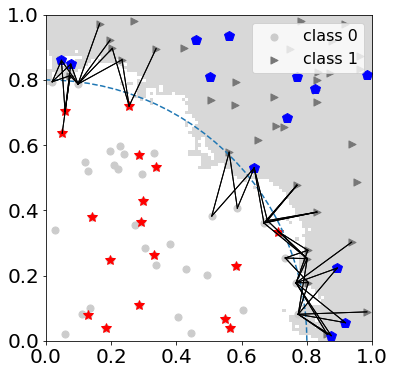

In [147]:
G.plot(cutdata[-1][1], figsize=(6, 6), light='#BBBBBB')
plt.imshow(resultgrad > .5, interpolation='none', extent=[0, 1, 0, 1], cmap='Greys', vmin=0, vmax=4)
plt.plot(Xsupport0[:, 0], Xsupport0[:, 1], c='red', ls='None', marker='*', markersize=10)
plt.plot(Xsupport1[:, 0], Xsupport1[:, 1], c='blue', ls='None', marker='p', markersize=10)
draw_arc()
plt.show()